## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns
pd.show_versions()
import sys
import graphviz
sys.executable
#import graphviz


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.5.final.0
python-bits: 32
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: None.None

pandas: 0.24.0
pytest: None
pip: 18.1
setuptools: 39.0.1
Cython: None
numpy: 1.14.3
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 6.4.0
sphinx: None
patsy: 0.5.1
dateutil: 2.7.3
pytz: 2018.4
blosc: None
bottleneck: None
tables: None
numexpr: None
feather: None
matplotlib: 2.2.2
openpyxl: None
xlrd: None
xlwt: None
xlsxwriter: None
lxml.etree: 4.2.5
bs4: None
html5lib: 1.0.1
sqlalchemy: None
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None
gcsfs: None


'c:\\users\\rapp\\appdata\\local\\programs\\python\\python36-32\\python.exe'

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

#### Do a test to make sure some pythonic lines of code work the way I think I do to bring data into a list format for the DecisionTree model

In [3]:
testtrain1 = []
testtrain2 = []
test_vars = ['LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_WindSpeed_mps']


#Method 1 [more pythonic]
loop_idx = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in test_vars:
    loop_idx = loop_idx & np.isfinite(asos_snotel_UA_df['2009':'2017'][v])

gv = pd.DataFrame()
#gv_asos_snotel_UA_df = asos_snotel_UA_df.copy
#gv_asos_snotel_UA_df = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx]
testlist1 = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx].apply(lambda x: x.tolist(), axis=1)
#testtrain2 = testlist.apply(lambda x: testtrain2.append(x))
testtrain1 = testlist1.tolist()


#Method 2 [less pythonic]
# Explicitly list each feature

compare_idx = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & \
           np.isfinite(asos_snotel_UA_df['2009':'2017']['LXV_Temperature_degC']) & \
           np.isfinite(asos_snotel_UA_df['2009':'2017']['LXV_Dewpoint_degC']) & \
           np.isfinite(asos_snotel_UA_df['2009':'2017']['LXV_WindSpeed_mps'])

for index, rows in asos_snotel_UA_df['2009':'2017'][compare_idx].iterrows(): 
    # Create list for the current row 
    testlist2 =[rows['LXV_Temperature_degC'], rows['LXV_WindSpeed_mps'], rows['LXV_Dewpoint_degC']] 
    # append the list to the final list 
    testtrain2.append(testlist2)
    
print(len(loop_idx), len(compare_idx))
print(loop_idx.equals(compare_idx))
print(testtrain2 == testtrain1)


6574 6574
True
True


### Now identify variables which have good data capture

**SURFACE FEATURES**

In [4]:

variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp']

good_vars_SFC = []
bad_vars_SFC = []

for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2006':'2017'][var])
 #   total_poss = len(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss_SFC = asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail_SFC =len(asos_snotel_UA_df['2006':'2017'][idx]) 
    
    if total_avail_SFC/total_poss_SFC >= 0.67: 
        good_vars_SFC.append(var)
    else:
        bad_vars_SFC.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars_SFC)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars_SFC)
    

Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp']
Variables with < 67% data match to snowfall: 
['CMtn_CloudCover_oktas', 'LXV_CloudCover_oktas']


**UPPER AIR**

In [5]:

variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars_UASFC = []
bad_vars_UASFC = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2006':'2017'][var])
 #   total_poss = len(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss_UASFC = asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail_UASFC =len(asos_snotel_UA_df['2006':'2017'][idx]) 
    
    if total_avail_UASFC/total_poss_UASFC >= 0.67: 
        good_vars_UASFC.append(var)
    else:
        bad_vars_UASFC.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars_UASFC)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars_UASFC)
    

Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

# Now try Cross Validation using Timeseries split

In [11]:

X_temp, X_feat_SFC, X_feat_UASFC = [], [], []
Y_temp, Y_actsnf_SFC, Y_actsnf_UASFC = [], [], []
idx_SFC, idx_UASFC = [],[]

#Surface features (X) and corresponding snowfall (Y)
idx_SFC = np.isfinite(asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in good_vars_UASFC:  #We DO want UASFC to dictate SFC feature selection
    idx_SFC = idx_SFC  & np.isfinite(asos_snotel_UA_df['2006':'2017'][v])
    print(v)

Y_temp= round(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2006':'2017'][idx_SFC],0)
Y_actsnf_SFC  = Y_temp.tolist()


X_temp = asos_snotel_UA_df['2006':'2017'][good_vars_SFC][idx_SFC].apply(lambda x: x.tolist(), axis=1)   # only want SFC variables 
X_feat_SFC = X_temp.tolist()
print(X_feat_SFC[0:5], Y_actsnf_SFC[0:5])


################################################
#UA and Surface features(X) and corresponding snowfall
idx_UASFC = np.isfinite(asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in good_vars_UASFC:
    idx_UASFC = idx_UASFC  & np.isfinite(asos_snotel_UA_df['2006':'2017'][v])
    print(v)

Y_temp= round(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2006':'2017'][idx_UASFC],0)
Y_actsnf_UASFC  = Y_temp.tolist()

X_temp = asos_snotel_UA_df['2006':'2017'][good_vars_UASFC][idx_UASFC].apply(lambda x: x.tolist(), axis=1)
X_feat_UASFC = X_temp.tolist()
print(X_feat_UASFC[0:5], Y_actsnf_UASFC[0:5])

print(np.mean(Y_actsnf_UASFC))   #check to make sure means are equivalent
print(np.mean(Y_actsnf_SFC))
Y_actsnf = Y_actsnf_SFC   # both UASFC and SFC tests will use same actual snowfall values

CMtnSNTL_Temp_degC
CMtn_Temperature_degC
CMtn_Dewpoint_degC
CMtn_WindDirection_deg
CMtn_WindSpeed_mps
LXV_Temperature_degC
LXV_Dewpoint_degC
LXV_Pressure_hp
LXV_WindSpeed_mps
LXV_WindDirection_deg
LXV_12hr_delta_Pressure_hp
KGJT_200mb_height_m
KGJT_200mb_tmpc
KGJT_200mb_dwpc
KGJT_200mb_drct
KGJT_200mb_speed_kts
KGJT_250mb_height_m
KGJT_250mb_tmpc
KGJT_250mb_dwpc
KGJT_250mb_drct
KGJT_250mb_speed_kts
KGJT_300mb_height_m
KGJT_300mb_tmpc
KGJT_300mb_dwpc
KGJT_300mb_drct
KGJT_300mb_speed_kts
KGJT_400mb_height_m
KGJT_400mb_tmpc
KGJT_400mb_dwpc
KGJT_400mb_drct
KGJT_400mb_speed_kts
KGJT_500mb_height_m
KGJT_500mb_tmpc
KGJT_500mb_dwpc
KGJT_500mb_drct
KGJT_500mb_speed_kts
KGJT_700mb_height_m
KGJT_700mb_tmpc
KGJT_700mb_dwpc
KGJT_700mb_drct
KGJT_700mb_speed_kts
KGJT_850mb_height_m
KGJT_d850_700_height_m
KGJT_d850_500_height_m
KGJT_d850_400_height_m
KGJT_d850_300_height_m
KGJT_d850_250_height_m
KGJT_d850_200_height_m
KGJT_d700_500_height_m
KGJT_d700_500_tmpc
KGJT_d700_500_dwpc
KGJT_d700_500_drct
KGJT

# Surface K Fold

KFold(n_splits=10, random_state=None, shuffle=False)
213
213
<generator object _BaseKFold.split at 0x048781E0>
TRAIN: [ 22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
22
TRAIN: [  0   1   2   3   4  

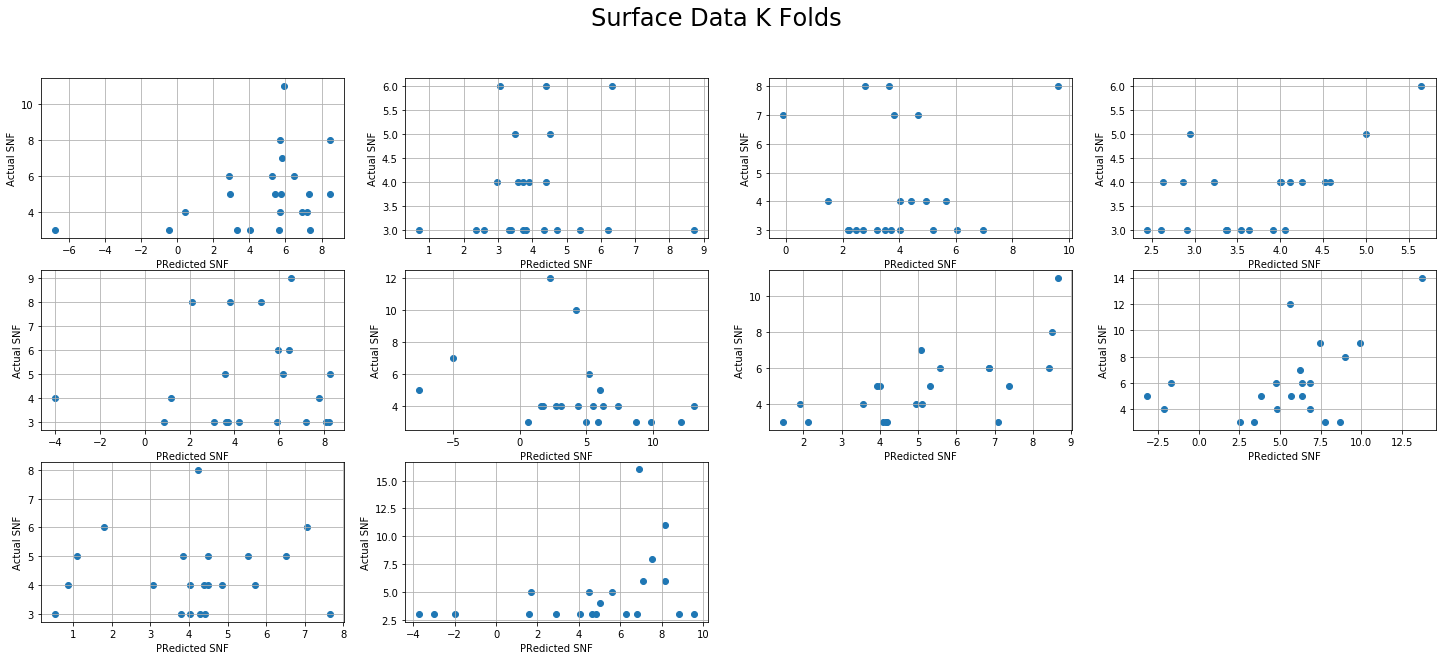

In [22]:
from sklearn.model_selection import TimeSeriesSplit # import KFold
from sklearn.model_selection import KFold # import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
lm = linear_model.LinearRegression()

from scipy.stats import pearsonr, linregress
#from sklearn.metrics import mean_squared_error
from sklearn import metrics


tscv = KFold(n_splits=10)
print(tscv)  
print(len(X_feat_SFC))
print(len(Y_actsnf))

print(tscv.split(X_feat_SFC))
slopes_SFC, intercepts_SFC, r_values_SFC, p_values_SFC, std_errs_SFC,  rmse_SFC = [],[],[],[],[], [] 
R2_scores_SFC =[]

X_train = np.array([])
 
    
#Surface Only
fig = plt.figure(figsize=(25,10))
fig.suptitle('Surface Data K Folds', fontsize=24)
count = 1
for train_index, test_index in tscv.split(X_feat_SFC):
 print("TRAIN:", train_index, "TEST:", test_index)
 X_train =  np.array(X_feat_SFC)[train_index]
 X_test =  np.array(X_feat_SFC)[test_index]
 Y_train =  np.array(Y_actsnf)[train_index]
 Y_test =   np.array(Y_actsnf)[test_index]
 model = lm.fit(X_train, Y_train)
 #Y_predsnf = lm.predict(X_test)
 Ytest_predictions = cross_val_predict(model, X_test, Y_test, cv = 21)
 print(len(Y_test))
 R2_scores_SFC.append(metrics.r2_score(Ytest_predictions, Y_test))
 slope, intercept, r_value, p_value, std_err = linregress(Ytest_predictions, Y_test)    
 slopes_SFC.append(slope)
 intercepts_SFC.append(intercept)
 r_values_SFC.append(r_value)
 p_values_SFC.append(p_value)
 std_errs_SFC.append(std_err)
 mse = mean_squared_error(Ytest_predictions, Y_test)
 rmse_SFC.append(np.sqrt(mse))  
     
 ax = fig.add_subplot(3,4,count)
 ax.scatter(Ytest_predictions, Y_test)
 ax.set_xlabel('PRedicted SNF', fontsize = 10)
 ax.set_ylabel('Actual SNF', fontsize = 10)

 ax.grid(True)
 count = count +1




Mean R2 Score=-0.19735841296612322
Mean p value =0.35501682946519464
MIn p value =0.0005986583689759092


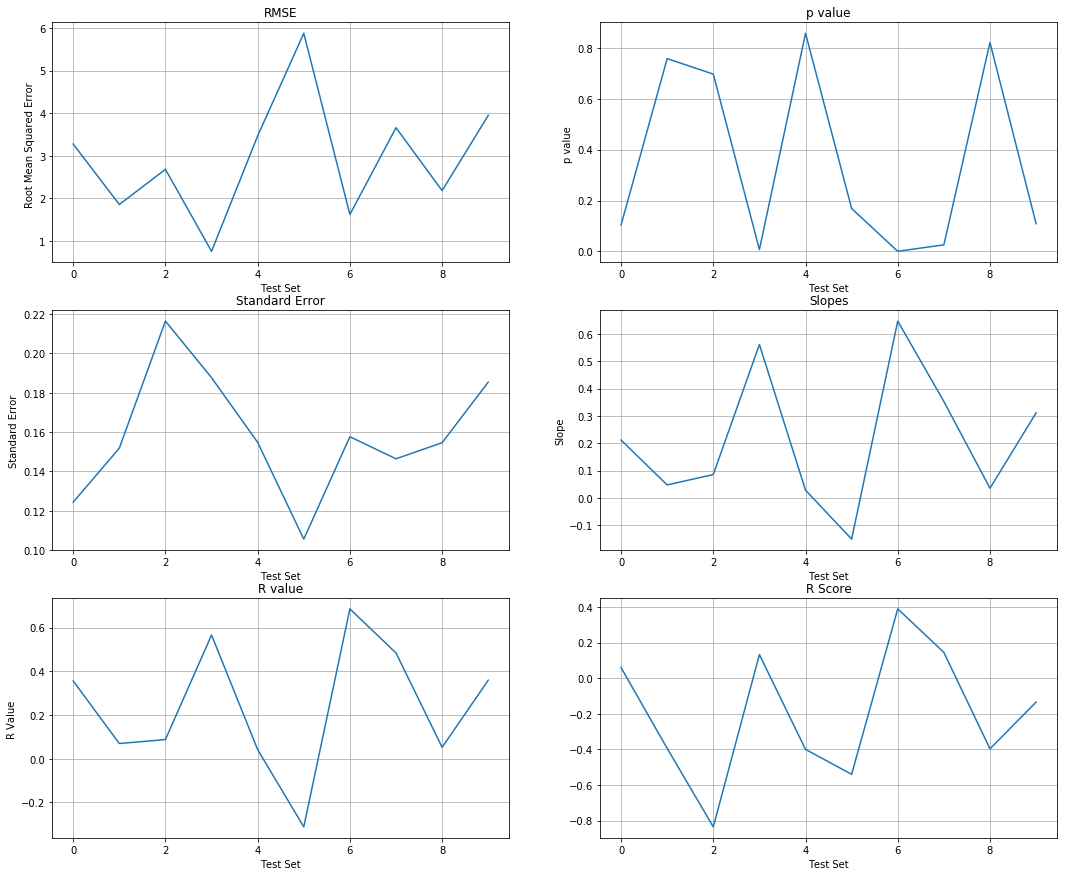

In [23]:
print("Mean R2 Score=" + str(np.mean(R2_scores_SFC)))
print("Mean p value =" +str(np.mean(p_values_SFC)))
print("MIn p value ="+str(np.min(p_values_SFC)))


fig = plt.figure(figsize=(18,15))  
#fig.suptitle('Surface Data K Folds', fontsize=24)

ax = fig.add_subplot(321)
ax.plot(rmse_SFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('Root Mean Squared Error ', fontsize = 10)
ax.set_title('RMSE')
ax.grid(True)


ax = fig.add_subplot(322)
ax.plot(p_values_SFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('p value ', fontsize = 10)
ax.set_title('p value')
ax.grid(True)



ax = fig.add_subplot(323)
ax.plot(std_errs_SFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('Standard Error', fontsize = 10)
ax.set_title('Standard Error')
ax.grid(True)


ax = fig.add_subplot(324)
ax.plot(slopes_SFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('Slope', fontsize = 10)
ax.set_title('Slopes')
ax.grid(True)

ax = fig.add_subplot(325)
ax.plot(r_values_SFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('R Value ', fontsize = 10)
ax.set_title('R value')
ax.grid(True)

ax = fig.add_subplot(326)
ax.plot(R2_scores_SFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_title('R Score')
ax.grid(True)



plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/SFC_KFolds_stats.png',bbox_inches='tight')
plt.show()

In [25]:
# Necessary imports: 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

#scores = cross_val_score(model, X_feat, Y_actsnf, cv=TimeSeriesSplit(n_splits=5).split(X_feat))
scores = cross_val_score(model, X_feat_SFC, Y_actsnf, cv=tscv.split(X_feat_SFC))
print(scores)
print(np.mean(scores))




[-0.05262772 -0.47630434  0.00411415 -2.89829764 -0.18381369  0.08433939
 -0.05581645 -0.32898167 -0.07255458  0.100147  ]
-0.38797955485772323


# Surface+Upper Air KFold

KFold(n_splits=10, random_state=None, shuffle=False)
213
213
<generator object _BaseKFold.split at 0x120163F0>
TRAIN: [ 22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
22
TRAIN: [  0   1   2   3   4  

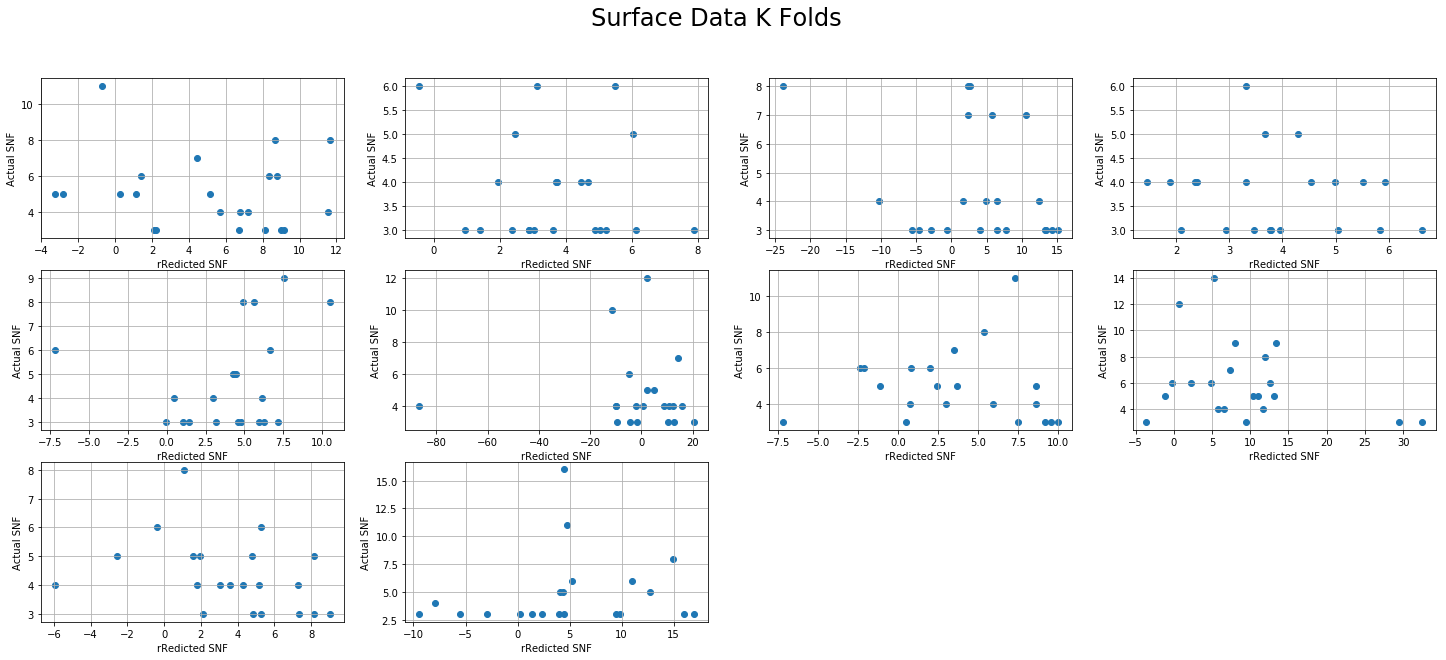

In [27]:
from sklearn.model_selection import TimeSeriesSplit # import KFold
from sklearn.model_selection import KFold # import KFold

from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error


tscv = KFold(n_splits=10)
print(tscv)  
print(len(X_feat_UASFC))
print(len(Y_actsnf))

print(tscv.split(X_feat_UASFC))

slopes_UASFC, intercepts_UASFC, r_values_UASFC, p_values_UASFC, std_errs_UASFC,  rmse_UASFC = [],[],[],[],[], [] 
R2_scores_UASFC =[]
all_Ytest_predictions_UASFC, all_Ytests_UASFC = [], []

X_train = np.array([])
 
    
#Surface Only
fig = plt.figure(figsize=(25,10))
fig.suptitle('Surface Data K Folds', fontsize=24)
count = 1
for train_index, test_index in tscv.split(X_feat_UASFC):
 print("TRAIN:", train_index, "TEST:", test_index)
 X_train =  np.array(X_feat_UASFC)[train_index]
 X_test =  np.array(X_feat_UASFC)[test_index]
 Y_train =  np.array(Y_actsnf)[train_index]
 Y_test =   np.array(Y_actsnf)[test_index]
 model = lm.fit(X_train, Y_train)
 #Y_predsnf = lm.predict(X_test)
 Ytest_predictions = cross_val_predict(model, X_test, Y_test, cv = 21)
 print(len(Y_test))
 R2_scores_UASFC.append(metrics.r2_score(Ytest_predictions, Y_test))
 slope, intercept, r_value, p_value, std_err = linregress(Ytest_predictions, Y_test)    
 slopes_UASFC.append(slope)
 intercepts_UASFC.append(intercept)
 r_values_UASFC.append(r_value)
 p_values_UASFC.append(p_value)
 std_errs_UASFC.append(std_err)
 mse = mean_squared_error(Ytest_predictions, Y_test)
 rmse_UASFC.append(np.sqrt(mse))  
 all_Ytest_predictions_UASFC.append(all_Ytest_predictions_UASFC)
 all_Ytests_UASFC.append(all_Ytests_UASFC)

     
 ax = fig.add_subplot(3,4,count)
 ax.scatter(Ytest_predictions, Y_test)
 ax.set_xlabel('rRedicted SNF', fontsize = 10)
 ax.set_ylabel('Actual SNF', fontsize = 10)

 ax.grid(True)
 count = count +1


In [ ]:
plt.scatter(all_Ytest_predictions_UASFC,  all_Ytests_UASFC)
plt.show()


In [ ]:
print("Mean R2 Score=" + str(np.mean(R2_scores_UASFC)))
print("Mean p value =" +str(np.mean(p_values_UASFC)))
print("MIn p value ="+str(np.min(p_values_UASFC)))


fig = plt.figure(figsize=(18,15))  
#fig.suptitle('Surface Data K Folds', fontsize=24)

ax = fig.add_subplot(321)
ax.plot(rmse_UASFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('Root Mean Squared Error ', fontsize = 10)
ax.set_title('RMSE')
ax.grid(True)


ax = fig.add_subplot(322)
ax.plot(p_values_UASFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('p value ', fontsize = 10)
ax.set_title('p value')
ax.grid(True)



ax = fig.add_subplot(323)
ax.plot(std_errs_UASFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('Standard Error', fontsize = 10)
ax.set_title('Standard Error')
ax.grid(True)


ax = fig.add_subplot(324)
ax.plot(slopes_UASFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('Slope', fontsize = 10)
ax.set_title('Slopes')
ax.grid(True)

ax = fig.add_subplot(325)
ax.plot(r_values_UASFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('R Value ', fontsize = 10)
ax.set_title('R value')
ax.grid(True)

ax = fig.add_subplot(326)
ax.plot(R2_scores_UASFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_title('R Score')
ax.grid(True)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/UASFC_KFolds_stats.png',bbox_inches='tight')
plt.show()


